In [69]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import csv
import pathlib
import os
import networkx as nx 
import matplotlib as mpl
import mpl_toolkits as bm
%matplotlib inline

# Function Defenition

## Data Wrangling Functions

## Read Power Data Func Def

In [70]:
#Get all scenarios in a directory

def get_scenario_names(sen_name):
    lst = os.listdir(os.getcwd())
    lst = list(filter(lambda k: sen_name in k, lst))
    lst = list(filter(lambda k: '.jl' not in k, lst))
    lst = list(filter(lambda k: 'DACNon' not in k, lst))
    
    return lst    

def read_cost_data(dir_list):
    
    costs_df = pd.DataFrame(columns=["scenario_name", "total_cost", "Power", "H2", "CO2", "SynFuels"])

    for dir_name in dir_list:

        total_cost = pd.read_csv("./" + dir_name + "/Results/status.csv").iloc[0]["Objval"]#.drop([0])
        power_cost = pd.read_csv("./" + dir_name + "/Results/costs.csv").iloc[0]["Total"] * 1e-9
        h2_cost = pd.read_csv("./" + dir_name + "/Results/Results_HSC/HSC_costs.csv").iloc[0]["Total"] * 1e-9
        
        dac_cost= pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_total_costs.csv").iloc[0]["Total"]
        co2_comp_cost = pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_co2_capture_compression_total_cost.csv").iloc[0]["Total"]
        co2_stor_cost = pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_co2_storage_injection_total_cost.csv").iloc[0]["Total"]
        co2_pipe_cost = sum(pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_co2_pipeline_expansion.csv")["Fixed_Cost_Pipes"])
        
        csc_cost = (dac_cost+ co2_comp_cost + co2_stor_cost + co2_pipe_cost) * 1e-9
        
        synfuel_cost = 0
        
        if os.path.exists("./" + dir_name + "/Results/Results_SynFuels/"):
        
            synfuel_cost = pd.read_csv("./" + dir_name + "/Results/Results_SynFuels/SynFuel_costs.csv").iloc[0]["Total"] * 1e-9
        
        
        curr_costs_df = pd.DataFrame(index = [scenario_name_dict[dir_name]], columns=["scenario_name", "total_cost", "Power", "H2", "CO2", "SynFuels"], data=[[scenario_name_dict[dir_name],total_cost, power_cost, h2_cost, csc_cost, synfuel_cost]])
        #print(curr_costs_df)
        costs_df = costs_df.append(curr_costs_df)

    return costs_df

    

In [71]:
def read_power_data(dir_list):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []
    power_gen_zone_list = []

    for dir_name in dir_list:

        resource_dict = {'CCGT' : 'Gas', 'OCGT' : 'Gas', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind' , 'offwind-ac' : 'Wind', 'onwind' : 'Wind',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv("./" + dir_name + "/Results/power.csv").drop([0,1])
        weights_df = pd.read_csv("./" + dir_name + "/Results/time_weights.csv")
        capacity_df = pd.read_csv("./" + dir_name + "/Results/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})
        
        zones = power_long_df["zone"].unique()

        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','interval']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name])

        power_gen_list.append(power_gen_total_df)


        ######Generator Capacity##########

        #Aggregate capacity total capacity
        end_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_capacity_scenario_df = end_capacity_scenario_df.assign(capacity_gw = end_capacity_scenario_df["EndCap"] * 0.001).reset_index()

        power_cap_list.append(end_capacity_scenario_df)

        ######Battery Capacity###########

        end_battery_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_battery_capacity_scenario_df = end_battery_capacity_scenario_df.assign(capacity_mw = end_battery_capacity_scenario_df["EndEnergyCap"]).reset_index()

        power_battery_cap_list.append(end_battery_capacity_scenario_df)
        
        ######Comp Power and Capacity DF#####
        
        comb_power_capacity_df = pd.merge(power_gen_total_df, end_capacity_scenario_df, on = ['resource_type', 'scenario'])
        comb_power_capacity_df["cf"] = comb_power_capacity_df.gen / comb_power_capacity_df.EndCap / 8760
        
        comb_power_capacity_list.append(comb_power_capacity_df)
        
    return power_gen_list, power_cap_list, power_battery_cap_list, comb_power_capacity_list
    


In [72]:
def read_power_data_gas_granular(dir_list):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []

    for dir_name in dir_list:

        resource_dict = {'CCGT' : 'Gas_CCGT', 'OCGT' : 'Gas_OCGT', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind' , 'offwind-ac' : 'Wind', 'onwind' : 'Wind',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv("./" + dir_name + "/Results/power.csv").drop([0,1])
        weights_df = pd.read_csv("./" + dir_name + "/Results/time_weights.csv")
        capacity_df = pd.read_csv("./" + dir_name + "/Results/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})

        zones = power_long_df["zone"].unique()

        power_total_df = power_long_df.query("zone == 'Total'")
        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','interval']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name])

        power_gen_list.append(power_gen_total_df)


    return power_gen_list
    
    

In [73]:
def read_h2_data(h2_dir_list):


    h2_cap_list = []
    h2_gen_list = []
    h2_stor_cap_list = []
    
    for h2_dir_name in h2_dir_list:
        

        h2_discharge_df = pd.read_csv("./" + h2_dir_name + "/Results/Results_HSC/HSC_h2_generation_discharge.csv").drop([0,1])
        weights_df = pd.read_csv("./" + h2_dir_name + "/Results/time_weights.csv")
        h2_capacity_df = pd.read_csv("./" + h2_dir_name + "/Results/Results_HSC/HSC_generation_storage_capacity.csv")

        h2_discharge_long_df = h2_discharge_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        h2_discharge_long_df =  h2_discharge_long_df.assign(
                                interval = pd.to_numeric(h2_discharge_long_df["Resource"].str[1:]) )

        h2_discharge_long_df = h2_discharge_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        mask = h2_discharge_long_df["variable"].str.contains("Above_ground_storage")
        h2_discharge_long_df = h2_discharge_long_df[~mask]

        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"


        h2_discharge_total_df = h2_discharge_long_df.query("variable != 'Total'").assign(h2_prod = h2_discharge_long_df["value"] * h2_discharge_long_df["Weight"]*0.001).groupby(['resource_type']).agg({'h2_prod': 'sum'}).reset_index()
        h2_discharge_total_df = h2_discharge_total_df.assign(scenario = scenario_name_dict[h2_dir_name])

        h2_gen_list.append(h2_discharge_total_df)

        mask = h2_capacity_df["Resource"].str.contains("Above_ground_storage")
        h2_storage_capacity_df = h2_capacity_df[mask]
        h2_capacity_df = h2_capacity_df[~mask]


        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"

        h2_storage_capacity_df["Resource"] = "Above Ground Storage"

        
        end_capacity_scenario_df = h2_capacity_df.query("Resource != 'Total'").groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name]).reset_index()

        h2_cap_list.append(end_capacity_scenario_df)
        
        end_storage_scenario_df = h2_storage_capacity_df.groupby(['Resource']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name]).reset_index()

        h2_stor_cap_list.append(end_storage_scenario_df)
        
    return h2_gen_list, h2_cap_list,h2_stor_cap_list

In [146]:
def read_emission_data(dir_list):

    emissions_df = pd.DataFrame(columns=["scenario_name", "Power Plant Emissions", "Power Plant PSC Abatement", "H2 Plant Emissions", "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement", "SF Emissions"])

    for dir_name in dir_list:

        curr_power_em = pd.read_csv("./" + dir_name + "/Results/emissions.csv").iloc[1,11] * 0.000001

        curr_hsc_em = pd.read_csv("./" + dir_name + "/Results/Results_HSC/HSC_emissions.csv").iloc[0,11]* 0.000001

        if os.path.isfile("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv"):
            curr_dac_cc = -1 * sum(pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv").iloc[1,1:])*0.000001
        else:
            curr_dac_cc = 0 
             
        # read the Excel file
        df = pd.read_csv("./" + dir_name +'/Results/Results_SynFuels/Syn_Fuel_Emissions_Balance.csv', header=None)       
        # Select the first three rows
        df = df.iloc[:3]      
        # Ignore the second row
        df = df.drop(1)
        # Set the column names as the values in the third row
        df.columns = df.iloc[0]
        # Sum the values in the third row for all columns except those containing "CO2_in"
        col_names = [col for col in df.columns if 'CO2_In' != col]
        csc_df = df[col_names]
        csc_total = (csc_df.iloc[1][1:]).astype(float).sum()* 0.0000001
        print(csc_total)
            
        curr_power_cc = -1 * sum(pd.read_csv("./" + dir_name + "/Results/Results_CSC/Power_zone_co2_captured.csv").iloc[1,1:])*0.000001
        curr_h2_cc = -1 * sum(pd.read_csv("./" + dir_name + "/Results/Results_CSC/Hydrogen_zone_co2_captured.csv").iloc[1,1:])*0.000001
        curr_dac_em = sum(pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_co2_fuel_emission_zone.csv").iloc[1,1:])*0.000001

        curr_emissions_df = pd.DataFrame(index = [scenario_name_dict[dir_name]], columns=["scenario_name", "Power Plant Emissions", "Power Plant PSC Abatement", "H2 Plant Emissions", "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement", "SF Emissions"], 
                                         data=[[scenario_name_dict[dir_name], curr_power_em, curr_power_cc, curr_hsc_em, curr_h2_cc, curr_dac_em, curr_dac_cc, csc_total]])
        
        emissions_df = emissions_df.append(curr_emissions_df)
        
    emissions_summary_df = pd.DataFrame()
    emissions_summary_df["Net Power Plant Emissions"] = emissions_df["Power Plant Emissions"] 
    emissions_summary_df["Net H2 Plant Emissions"] = emissions_df["H2 Plant Emissions"] 
    emissions_summary_df["Net DAC Plant Emissions"] = emissions_df["DAC Plant Emissions"] + emissions_df["DAC Abatement"]
    emissions_summary_df["SF Emissions"] = emissions_df["SF Emissions"]
    
    
    return emissions_df, emissions_summary_df

read_emission_data(s1_scenario_list)

507.64802299367636
505.4765078517553
505.72814941729285
517.2510142671467


(                           scenario_name  Power Plant Emissions  \
 High_Elec                      High_Elec              28.468819   
 High_Elec_w_Eff_Pes  High_Elec_w_Eff_Pes              30.743791   
 High_Elec_w_Eff_Opt  High_Elec_w_Eff_Opt              27.198822   
 High_H2                          High_H2              32.004017   
 
                      Power Plant PSC Abatement  H2 Plant Emissions  \
 High_Elec                           -98.897165           43.547880   
 High_Elec_w_Eff_Pes                 -89.683617           43.904640   
 High_Elec_w_Eff_Opt                 -91.331573           44.073384   
 High_H2                             -85.824265           43.773930   
 
                      H2 Plant PSC Abatement  DAC Plant Emissions  \
 High_Elec                       -682.250070            83.710608   
 High_Elec_w_Eff_Pes             -687.839332            83.830230   
 High_Elec_w_Eff_Opt             -690.483014            83.015972   
 High_H2                 

In [116]:
def read_sen_emissions_costs(dir_list):
    
    sen_results_df = pd.DataFrame(columns=["scenario_name", "sen_factor", "curr_cost", "captured_co2"])

    for sen_file in dir_list:

        curr_cost = pd.read_csv("./" + sen_file + "/Results/status.csv").iloc[0]["Objval"]#.drop([0])
        curr_csc_em = sum(pd.read_csv("./" + sen_file + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv").iloc[1,1:])*0.000001
        curr_sen_factor = float(sen_file[-3:])

        curr_sen_results_df = pd.DataFrame(columns=["scenario_name","sen_factor", "curr_cost", "captured_co2"],
                                           data=[[sen_file, curr_sen_factor, curr_cost, curr_csc_em]])

        sen_results_df = sen_results_df.append(curr_sen_results_df)


    return(sen_results_df.sort_values(by = "sen_factor"))

In [76]:
def read_h2_balance(h2_dir_list):
    
    h2_balance = []
    
    zone_dict = {"1" : "Belguim",
                "2" : "Germany",
                "3" : "Denmark_1",
                "4" : "Denmark_2",
                "5" : "France",
                "6" : "UK_1",
                "7" : "UK_2",
                "8" : "Netherlands",
                "9" : "Norway",
                "10" : "Sweden",}
    
    for h2_dir_name in h2_dir_list:
        curr_h2_balance_df = pd.read_csv("./" + h2_dir_name + "/Results/Results_HSC/HSC_h2_balance.csv", index_col = 0, header = None).head(3)#.melt()
        curr_h2_balance_df = pd.DataFrame(data = {'scenario_name' : scenario_name_dict[h2_dir_name], 
                                                  'var' : curr_h2_balance_df.iloc[0],
                                                  'zone' :curr_h2_balance_df.iloc[1], 'value' :curr_h2_balance_df.iloc[2]}).reset_index()
        
        #curr_h2_balance_df.loc[curr_h2_balance_df["index"].str.contains("Genertation"),"resource_type"] = "Electrolyzer"
        #h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_SMR"),"resource_type"] = "SMR"
        
        mask = curr_h2_balance_df["var"].str.contains("Generation")
        mask2 = curr_h2_balance_df["var"].str.fullmatch("Demand")
        
        curr_h2_balance_df = curr_h2_balance_df[mask | mask2]
        
        curr_h2_balance_df = curr_h2_balance_df.pivot(index = ['scenario_name', 'zone'], columns = ['var'], values = ['value']).reset_index()
        
        curr_h2_balance_df.columns = ["scenario", "zone", "demand", "generation"]
        
        curr_h2_balance_df[["demand", "generation"]] = curr_h2_balance_df[["demand", "generation"]].apply(pd.to_numeric)
        
        
        curr_h2_balance_df["demand"] = pd.Series(curr_h2_balance_df["demand"]) * -1
        
        curr_h2_balance_df = curr_h2_balance_df.replace({"zone": zone_dict})
        
        h2_balance.append(curr_h2_balance_df)

    return h2_balance


def fig_hydrogen_demand_supply_zonal(plot_df, title_str):
    
    scenario = plot_df["scenario"][0]

    labels = plot_df["zone"]
    demand = plot_df["demand"]
    generation = plot_df["generation"]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, demand, width, label='Demand')
    rects2 = ax.bar(x + width/2, generation, width, label='Generation')

    ax.set_ylabel('Hydrogen Demand (Tonnes)')
    ax.set_title(title_str + " " + scenario)

    ax.set_xticks(x) # values
    ax.set_xticklabels(labels, rotation = 45) # labels

    ax.legend()

    




## Figures Functions

### Create Power Gen Comp Fig Fun Def

In [77]:
def fig_compare_generation(power_gen_list, title_str):
    curr_df = pd.concat(power_gen_list).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index = 'scenario', columns = 'resource_type' )['generation_twh'].plot(kind = "bar", stacked = True, legend=True, xlabel = "Scenario", ylabel = "Total Generation (TWh)", title = title_str, color = ["springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=70)

In [78]:
def fig_compare_h2_prod(h2_gen_list, title_str):    
    pd.concat(h2_gen_list).pivot(index = 'scenario', columns = 'resource_type' )['h2_prod'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in H2 Discharge (kTonnes)", title = title_str, xlabel = "",  color = ["grey","green",  "dodgerblue"]).legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=70)
    plt.show()

In [79]:
### Create Battery Comp Fig Fun Def

In [80]:
def fig_comp_battery(power_gen_list, title_str):
    pd.concat(power_gen_list).query('resource_type == "Battery"').pivot(index = 'scenario', columns = 'resource_type' )['generation_twh'].plot(kind = "bar", stacked = True, legend=False, xlabel = "Scenario", ylabel = "Total Generation (TWh)", title = title_str, color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"])#.legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)
    

In [81]:
### Create Single Resource Comp Fig Fun Def

def fig_comp_battery(power_gen_list,title_str):
    
    pd.concat(power_gen_list).query("resource_type == 'Battery'").pivot(index = 'scenario', columns = 'resource_type' )['generation_twh'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Total Discharge (TWh)",xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))

def fig_comp_battery_cap(power_gen_list,title_str):
    
    pd.concat(power_gen_list).query("resource_type == 'Battery'").pivot(index = 'scenario', columns = 'resource_type' )['capacity_gw'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Total Capacity (GW)",xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))


def fig_comp_h2_storage_cap(h2_stor_list,title_str):
    
    pd.concat(h2_stor_list).pivot(index = 'scenario', columns = 'Resource' )['EndEnergyCap'].plot(kind = "bar", stacked = True, legend=False, ylabel = "H2 Storage (Tonnes)", xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))


In [82]:
def fig_comp_cost(costs_df, title_str):

    costs_df.assign(curr_cost = costs_df["curr_cost"] * 0.001).plot(kind = "bar", legend = False, ylabel = "Total System Cost (B EUR)", xlabel = "Scenario", title = title_str)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)

In [83]:
def fig_emissions_sector(emissions_df):
    emissions_df.plot(kind = "bar", ylabel = "Sector Emissions (MTonnes)", xlabel = "Scenario", title = "Emissions by Sector")

    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)


In [84]:
def fig_comp_capacity(power_cap_list, title_str):
    pd.concat(power_cap_list).pivot(index = 'scenario', columns = 'resource_type' )['capacity_gw'].plot(color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"], kind = "bar", title = title_str, stacked = True, legend=False, ylabel = "Capacity (GW)").legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)

In [85]:
def fig_comp_h2_cap(h2_cap_list, title_str):    
    pd.concat(h2_cap_list).pivot(index = 'scenario', columns = 'resource_type' )['EndCap'].plot(kind = "bar", stacked = True, legend=True, ylabel = "H2 Discharge Capacity (kTonnes/Hr)", title = title_str, xlabel = "",  color = ["green", "grey", "dodgerblue"]).legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)


In [86]:
#Cost Sensitivity Figure
def fig_var_sen(df, title, var, ylab, ylim = None, ymult = 1):
    x = df.sen_factor
    y = df[var]
    df = pd.DataFrame({'sensitivity':x, 'var':y})

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel(ylab)
    ax1.set_xlabel('Scenario')
    ax1.set_title(title)

    line, = ax1.plot(x, y * ymult)
    
    if ylim is not None:
        ax1.set_ylim(ylim)
    
    return fig



In [87]:

def fig_comp_power_cap_to_base(power_cap_list, fig_title, plt_lim = None):
    base_power_cap_df = power_cap_list[0]
    comp_power_cap_df = pd.concat(power_cap_list[1:]).merge(base_power_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_power_cap_df = comp_power_cap_df.assign(diff = comp_power_cap_df["capacity_gw_x"] - comp_power_cap_df["capacity_gw_y"])
    comp_power_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, xlabel = 'Scenario', ylabel = "Change in Power Capacity (GW)", title = fig_title, color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"] ).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 50)
    ax = plt.gca()
    
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.rcParams.update({'font.size': 20})
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(labels[::-1])

In [88]:

def fig_comp_h2_cap_to_base(h2_cap_list, fig_title, plt_lim = None):
    base_h2_cap_df = h2_cap_list[0]
    comp_h2_cap_df = pd.concat(h2_cap_list[1:]).merge(base_h2_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_h2_cap_df = comp_h2_cap_df.assign(diff = comp_h2_cap_df["h2_cap_x"] - comp_h2_cap_df["h2_cap_y"])
    comp_h2_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, xlabel = 'Scenario', ylabel = "Change in H2 Prod Capacity (Mtonnes/Hr)", title = fig_title, color =  ["green", "grey", "dodgerblue"] ).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 50)
    ax = plt.gca()
    
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.rcParams.update({'font.size': 20})
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(labels[::-1])

In [89]:
 def fig_comp_power_gen_to_base(power_gen_list, fig_title, plt_lim = None):
    base_power_gen_df = power_gen_list[0].query("resource_type != 'Battery' & resource_type != 'PHS'")
    comp_power_gen_df = pd.concat(power_gen_list[1:]).query("resource_type != 'Battery' & resource_type != 'PHS'").merge(base_power_gen_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_power_gen_df = comp_power_gen_df.assign(diff = comp_power_gen_df["generation_twh_x"] - comp_power_gen_df["generation_twh_y"])#.query("resource_type != 'PHS'& resource_type != 'Battery'")
    comp_power_gen_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in Power Generation (TWh)", title = fig_title, xlabel = "Scenario", color = ["springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.ylim([-175,175])
    plt.setp(labels, rotation=50)
    plt.show()

In [90]:

def fig_comp_h2_prod_to_base(h2_cap_list, fig_title, plt_lim = None):
    base_h2_cap_df= h2_cap_list[0]
    comp_h2_cap_df = pd.concat(h2_cap_list[1:]).merge(base_h2_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_h2_cap_df = comp_h2_cap_df.assign(diff = comp_h2_cap_df["h2_prod_x"] - comp_h2_cap_df["h2_prod_y"])
    comp_h2_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, xlabel = 'Scenario', ylabel = "Change in H2 Prod (Mtonnes)", title = fig_title, color =  ["grey", "green", "dodgerblue"] ).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 50)
    ax = plt.gca()
    
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.rcParams.update({'font.size': 20})
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(labels[::-1])

In [91]:
def create_power_dispatch_figure (dir_name, title_str):

    period_days = range(179,186)

    period_map = pd.read_csv("./" + dir_name + "/TDR_Results/Period_map.csv")

    power_df = pd.read_csv("./" + dir_name + "/Results/power.csv")
    power_df = power_df.iloc[2:]#... #remove excess rows at the beginning

    period_map = period_map[period_map.Period_Index.isin(period_days)]

    rep_periods = period_map.Rep_Period_Index #collect rep periods

    rep_power_df = []
    i = 0 

    for rep_period in rep_periods:
        curr_power_df = power_df.iloc[24 * (rep_period -1) -1  : rep_period* 24 -1] #Filter rows from (rep_period -1) * 24 + 1: rep_period*24
        curr_power_df.reset_index(drop=True, inplace=True)
        curr_power_df = curr_power_df.assign(new_interval = pd.Series(range(i*24 + 1, (i+1) * 24 + 1 )))
        i += 1

        rep_power_df.append(curr_power_df)

    resource_dict = {'CCGT' : 'Gas', 'OCGT' : 'Gas', 'CCGT_CCS' : 'Gas w/ CCS',
                 'biomass' : 'Biomass',
                 'coal' :'Coal',
                 'lignite' : 'Coal',
                 'oil' : 'Oil',
                 'offwind-dc' : 'Wind' , 'offwind-ac' : 'Wind', 'onwind' : 'Wind',
                'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
                 'solar' : 'Solar',
                'nuclear' : 'Nuclear'}    


    power_df = pd.concat(rep_power_df)

    #Wrangle Power Data into long format
    power_long_df = power_df.melt(id_vars = ["Resource", "new_interval"]).query("Resource != 'Zone' & Resource != 'AnnualSum'")


    power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                             resource_type = power_long_df["variable"].str[6:],
                            interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})

    power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','new_interval']).agg({'value': 'sum'}).reset_index()

    power_gen_df["generation_gw"] = power_gen_df.value * 0.001

    power_gen_df = power_gen_df.pivot(index = 'new_interval', columns = 'resource_type')['generation_gw']

    power_gen_df.plot.area(xlabel = 'Hour', ylabel = 'Generation (GW)', title = title_str,color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"]).legend(bbox_to_anchor= (1,1))

    plt.xlim([1,168])

In [92]:
def create_h2_dispatch_figure (dir_name, title_str):

    period_days = range(179,186)

    period_map = pd.read_csv("./" + dir_name + "/TDR_Results/Period_map.csv")

    h2_discharge_df = pd.read_csv("./" + dir_name + "/Results/Results_HSC/HSC_h2_generation_discharge.csv")
    h2_discharge_df = h2_discharge_df.iloc[2:]#... #remove excess rows at the beginning

    period_map = period_map[period_map.Period_Index.isin(period_days)]

    rep_periods = period_map.Rep_Period_Index #collect rep periods

    rep_h2_discharge_df = []
    i = 0 

    for rep_period in rep_periods:
        curr_h2_discharge_df = h2_discharge_df.iloc[24 * (rep_period -1) -1  : rep_period* 24 -1] #Filter rows from (rep_period -1) * 24 + 1: rep_period*24
        curr_h2_discharge_df.reset_index(drop=True, inplace=True)
        curr_h2_discharge_df = curr_h2_discharge_df.assign(new_interval = pd.Series(range(i*24 + 1, (i+1) * 24 + 1 )))
        i += 1

        rep_h2_discharge_df.append(curr_h2_discharge_df)
        
    h2_discharge_df = pd.concat(rep_h2_discharge_df)
    
    h2_discharge_long_df = h2_discharge_df.melt(id_vars = ["Resource", "new_interval"]).query("Resource != 'Zone' & Resource != 'AnnualSum'")
    #mask = h2_discharge_long_df["variable"].str.contains("Above_ground_storage")
    #h2_discharge_long_df = h2_discharge_long_df[~mask]

    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Small_Electrolyzer"),"resource_type"] = "Electrolyzer"
    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_SMR"),"resource_type"] = "SMR"
    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_SMR_wCCS"),"resource_type"] = "SMR w/ CCS"
    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Storage"),"resource_type"] = "H2 Storage Discharge"
    
    h2_gen_df = h2_discharge_long_df.query("variable != 'Total'").groupby(['resource_type','new_interval']).agg({'value': 'sum'}).reset_index()

    h2_gen_df = h2_gen_df.pivot(index = 'new_interval', columns = 'resource_type')['value']

    h2_gen_df.plot.area(xlabel = 'Hour', ylabel = 'H2 Discharge (Tonnes)', title = title_str,color = ["green", "grey", "dodgerblue", "red"]).legend(bbox_to_anchor= (1,1))

    plt.xlim([1,168])
    
def fig_emissions_breakdown(emissions_summary_data, title_str, total_emissions):
    emissions_summary_data.plot(kind = 'barh', width = 0.8, ylabel = "CO2 Emissions (MTonnes)", xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))

    plt.vlines(total_emissions,-1,9, label = "Total Emissions")
    ax = plt.gca()
    ax.set_xlabel("CO2 Emissions (MTonnes)")
    plt.legend(bbox_to_anchor= (1,1))
    
def fig_cost_breakdown(cost_data, title_str):
    cost_data.loc[:, cost_data.columns != "total_cost"].plot(kind = 'bar', stacked = True , ylabel = "Total System Cost (B EUR)", xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))

def fig_dac_zonal(dir_name, title_str):
    curr_power_em = pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv").iloc[1,1:]
    curr_power_em = pd.DataFrame(curr_power_em).assign( zone = ["BE", "DE", "DK1", "DK2", "FR", "GB1", "GB2", "NL", "NO", "SE"]).reset_index().set_index("zone")#.rename(columns = {'emissions_red' : '1'}, inplace = True)

    #"Emission Reduction DAC by Zone"
    curr_power_em.plot(kind = "bar", legend = False, title = title_str, ylabel = "Emission Reduction by Zone (Tonnes of CO2)")
    

#locs, labels = xticks()
#xticks(["BE", "DE", "DK1", "DK2", "FR", "GB1", "GB2", "NL", "NO", "SE"])

[('BE0', 'FR0'), ('BE0', 'NL0'), ('DE0', 'DK3'), ('DE0', 'FR0'), ('DE0', 'NL0'), ('DK0', 'SE3'), ('DK3', 'DK0'), ('NO3', 'DK0'), ('DK3', 'SE3'), ('FR0', 'GB5'), ('GB5', 'GB4'), ('NL0', 'GB5'), ('NO3', 'NL0'), ('NO3', 'SE3')]


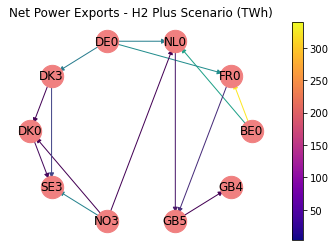

[('BE0', 'FR0'), ('BE0', 'NL0'), ('DE0', 'DK3'), ('DE0', 'FR0'), ('DE0', 'NL0'), ('DK0', 'SE3'), ('DK3', 'DK0'), ('NO3', 'DK0'), ('DK3', 'SE3'), ('FR0', 'GB5'), ('GB5', 'GB4'), ('NL0', 'GB5'), ('NO3', 'NL0'), ('NO3', 'SE3')]


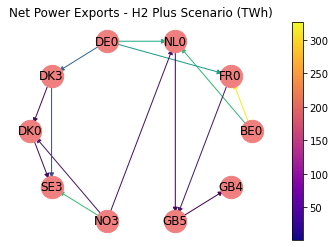

[('BE0', 'FR0'), ('BE0', 'NL0'), ('DE0', 'DK3'), ('DE0', 'FR0'), ('DE0', 'NL0'), ('DK0', 'SE3'), ('DK3', 'DK0'), ('NO3', 'DK0'), ('DK3', 'SE3'), ('FR0', 'GB5'), ('GB5', 'GB4'), ('NL0', 'GB5'), ('NO3', 'NL0'), ('NO3', 'SE3')]


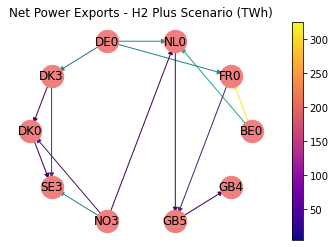

In [101]:
def read_power_flows(dir_name):
    
    trans_map = pd.read_csv("./" + dir_name + "/network.csv")
    flows_df = pd.read_csv("./" + dir_name + "/Results/flow.csv").iloc[0,:]
    
    country_map_dict = trans_map.iloc[:,0:2]
    country_map_dict = country_map_dict[np.invert(country_map_dict.iloc[:,0].isna())]
    
    country_map_dict.columns = ["country", "zones"]
    country_map_dict["country"] = country_map_dict["country"].str[0:3]
    
    country_map_dict = dict(zip(country_map_dict["zones"].to_list(), country_map_dict["country"].to_list()))
    
    
    lines = trans_map.iloc[:,2:13].melt(id_vars = ["Network_Lines"], var_name = "zone", value_name = "dir").query('dir != 0')\
        .pivot(index = ["Network_Lines"], columns = ["dir"], values = ["zone"]).reset_index()
    lines.columns = lines.columns.to_flat_index()
    lines.columns = ["lines", "zone_neg", "zone_pos"]
    lines.set_index(["lines"], inplace = True)
    
    
    #print(flows_df.reset_index().iloc[1:-1,1])
    lines["flow"] = flows_df.reset_index().iloc[1:-1,1]
    
    new_line_flow_df = pd.DataFrame(columns = ["line", "zone_in", "zone_out", "flow"])
    
    for row in lines.iterrows():
        zone_in = row[1][0]
        zone_out = row[1][1]
        
        zone_in_f = float(zone_in[1:])
        zone_out_f = float(zone_out[1: ])
        
        flow = row[1][2]
        
        if zone_out_f < zone_in_f:
            zone_out_temp = zone_in
            zone_in = zone_out
            zone_out = zone_out_temp
            flow = flow * -1
            
        new_line_flow_df.loc[len(new_line_flow_df.index)] = [row[0], zone_in, zone_out, flow]
        #new_line_flow_df = pd.concat(new_line_flow_df,)
        
    
    line_flow_summarized_df = new_line_flow_df.groupby(["zone_in", "zone_out"]).sum().reset_index()
    
    line_flow_summarized_pos_df = pd.DataFrame(columns = ["zone_in", "zone_out", "flow"])
    
    for row in line_flow_summarized_df.iterrows():
        zone_in = row[1][0]
        zone_out = row[1][1]
        flow = row[1][2]
              
        if flow < 0:
            zone_out_temp = zone_in
            zone_in = zone_out
            zone_out = zone_out_temp
            flow = flow * -1
        
        line_flow_summarized_pos_df.loc[len(line_flow_summarized_pos_df.index)] = [zone_in, zone_out, flow*10e-6]
    
    line_flow_summarized_pos_df = line_flow_summarized_pos_df.query('flow != 0')
    line_flow_summarized_pos_df = line_flow_summarized_pos_df.replace({"zone_in" : country_map_dict, "zone_out" : country_map_dict})

    
    G = nx.DiGraph()
    
    elist = []
    eweight = []
    i = 0 
    
    for curr_line in line_flow_summarized_pos_df.iterrows():
        elist.append( (curr_line[1][0], curr_line[1][1]))
        eweight.append(curr_line[1][2])
        
        i = i+1
    print(elist)
    
    G.add_edges_from(elist)
    
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos,node_color="lightcoral", node_size = 500)
    nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, edgelist=elist, edge_color=eweight, arrows=True)
    
    cmap = plt.cm.plasma
    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(eweight)
    
    
    #m = bm.basemap.Basemap(projection='merc',
    #             llcrnrlon=-180,
    #             llcrnrlat=45,
    #             urcrnrlon=-50,
    #             urcrnrlat=65,
    #             lat_ts=0,
    #             resolution='l',
    #             suppress_ticks=True)

    ax = plt.gca()
    ax.set_axis_off()
    plt.colorbar(pc, ax=ax)
    plt.title("Net Power Exports - H2 Plus Scenario (TWh)")
    plt.show()
    
    #G.add_weighted_edges_from(elist)
    #nx.draw_networkx_labels(G, pos)
        
    #nx.draw(G,pos=nx.circular_layout(G), node_color='r')
    #print(pd.concat([flows_df, lines], axis = 1))
        
    #print(flows_df)
    #print(country_map_dict)
    #print(lines)
        
        
read_power_flows("S1_2040_90CombEC_ElecPlus_LF_Base")
read_power_flows("S1_2040_90CombEC_H2Plus_LF_Base")
read_power_flows("S1_2040_90CombEC_ElecPlus_Eff_Opt_LF_Base")
    

# Load Power Data

# FESC Fall 22 Slides

### S1 90% Cap Scenario

/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-73-27fc91b1125b>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

507.64802299367636
505.4765078517553
505.72814941729285
517.2510142671467


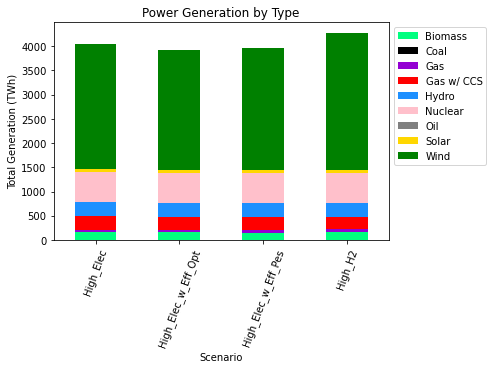

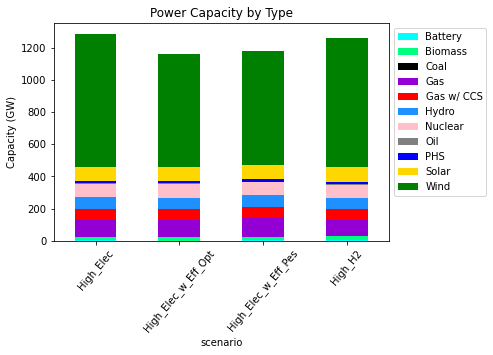

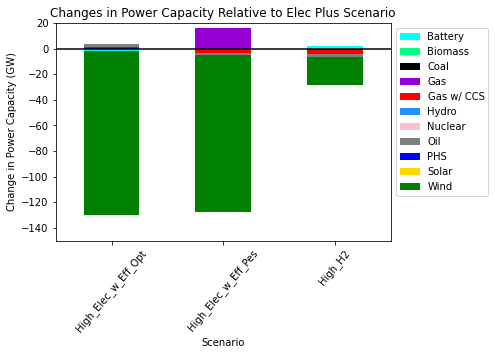

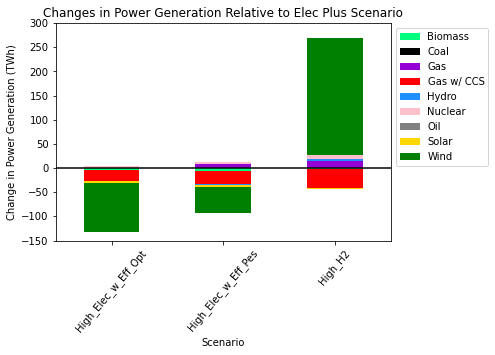

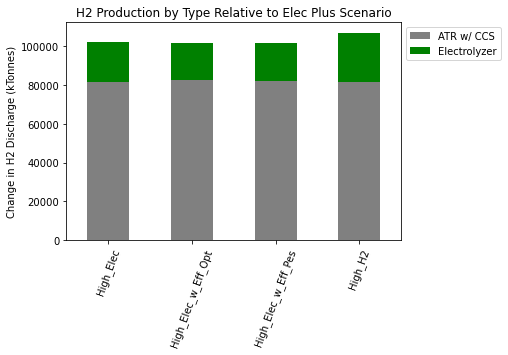

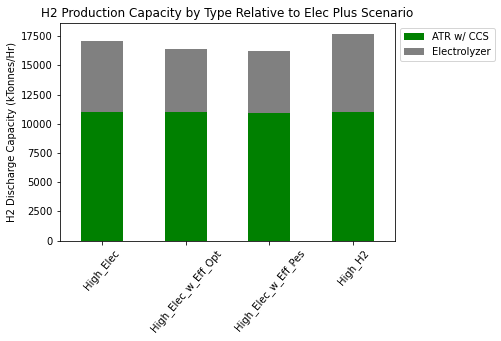

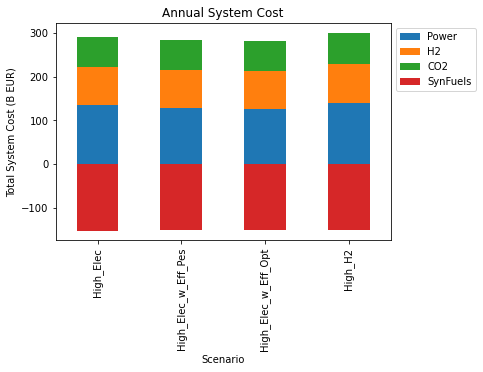

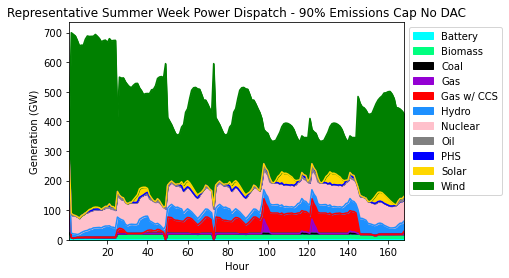

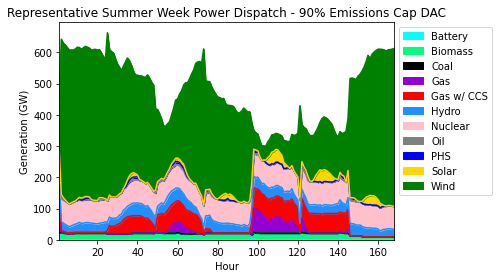

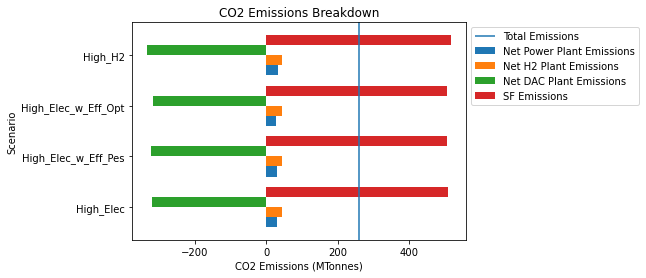

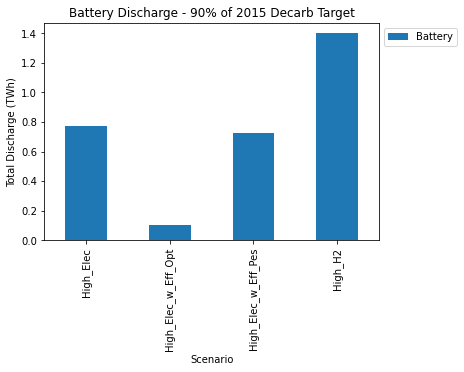

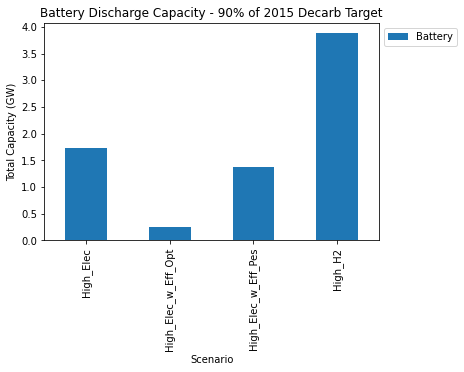

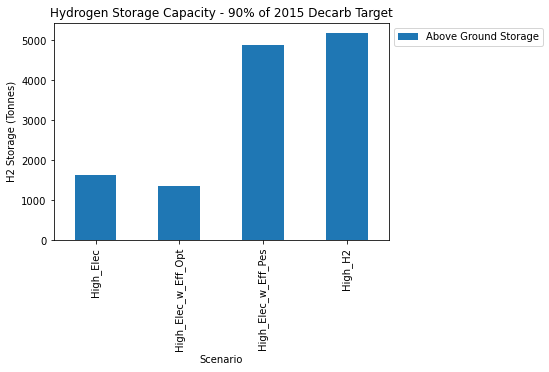

In [148]:
scenario_name_dict = {"S1_2040_90CombEC_ElecPlus_LF_Base":"High_Elec",
                      "S1_2040_90CombEC_ElecPlus_Eff_Pes_LF_Base_v2":"High_Elec_w_Eff_Pes",
                      "S1_2040_90CombEC_ElecPlus_Eff_Opt_LF_Base": "High_Elec_w_Eff_Opt",
                      "S1_2040_90CombEC_H2Plus_LF_Base": "High_H2"
                      }
s1_scenario_list = ["S1_2040_90CombEC_ElecPlus_LF_Base",
                    "S1_2040_90CombEC_ElecPlus_Eff_Pes_LF_Base_v2",
                    "S1_2040_90CombEC_ElecPlus_Eff_Opt_LF_Base",
                    "S1_2040_90CombEC_H2Plus_LF_Base"]


DATA_POWER_S1 = read_power_data(s1_scenario_list)
DATA_COST_S1 = read_cost_data(s1_scenario_list)
DATA_H2_S1 = read_h2_data(s1_scenario_list)
DATA_EMISSIONS_S1 = read_emission_data(s1_scenario_list)

fig_compare_generation(DATA_POWER_S1[0], "Power Generation by Type")
fig_comp_capacity(DATA_POWER_S1[1], "Power Capacity by Type" )
fig_comp_power_cap_to_base(DATA_POWER_S1[1], "Changes in Power Capacity Relative to Elec Plus Scenario" , [-150,20])
fig_comp_power_gen_to_base(DATA_POWER_S1[0], "Changes in Power Generation Relative to Elec Plus Scenario", [-150,300] )
fig_compare_h2_prod(DATA_H2_S1[0], "H2 Production by Type Relative to Elec Plus Scenario")
fig_comp_h2_cap(DATA_H2_S1[1], "H2 Production Capacity by Type Relative to Elec Plus Scenario")
#fig_comp_h2_cap_to_base(DATA_H2_S1[1], "Changes in H2 Capacity Relative to to Elec Plus Scenario" )
#fig_comp_h2_prod_to_base(DATA_H2_S1[0], "Changes in H2 Production Relative to Elec Plus Scenario" )
fig_cost_breakdown(DATA_COST_S1, "Annual System Cost")

create_power_dispatch_figure("S1_2040_90CombEC_ElecPlus_LF_Base" , "Representative Summer Week Power Dispatch - 90% Emissions Cap No DAC")
create_power_dispatch_figure("S1_2040_90CombEC_H2Plus_LF_Base" , "Representative Summer Week Power Dispatch - 90% Emissions Cap DAC")

#create_h2_dispatch_figure("S1_2040_90CombEC_ElecPlus_LF_Base" , "Representative Summer Week H2 Production Dispatch\n90% Emissions Cap No DAC")
#create_h2_dispatch_figure("S1_2040_90CombEC_H2Plus_LF_Base" , "Representative Summer Week H2 Production Dispatch\n90% Emissions Cap DAC")

fig_emissions_breakdown(DATA_EMISSIONS_S1[1], "CO2 Emissions Breakdown", 38+220)


fig_comp_battery(DATA_POWER_S1[0], "Battery Discharge - 90% of 2015 Decarb Target")
fig_comp_battery_cap(DATA_POWER_S1[1], "Battery Discharge Capacity - 90% of 2015 Decarb Target")
fig_comp_h2_storage_cap(DATA_H2_S1[2], "Hydrogen Storage Capacity - 90% of 2015 Decarb Target")

#fig_hydrogen_demand_supply_zonal(read_h2_balance(s1_scenario_list)[0], "Zonal Hydrogen Demand - 90% of 2015 Decarb Target")
#fig_hydrogen_demand_supply_zonal(read_h2_balance(s1_scenario_list)[4], "Zonal Hydrogen Demand - 90% of 2015 Decarb Target")


#fig_dac_zonal("S1_2040_90CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.4", "Emission Reduction DAC by Zone - 90% of 2015 Decarb Target 0.4x DAC")




In [ ]:
DATA_POWER_gran_S1 = read_power_data_gas_granular(s1_scenario_list)


df_gas_cons_power= pd.concat(DATA_POWER_gran_S1).query("resource_type == 'Gas_CCGT' |resource_type == 'Gas_OCGT'")
df_gas_cons_power= (df_gas_cons_power.assign(heatrate = np.where(df_gas_cons_power.resource_type == 'Gas_CCGT', 6.46,(np.where(df_gas_cons_power.resource_type == 'Gas_OCGT', 9.91, 7.12)))))

df_gas_cons_power = df_gas_cons_power.assign(gas_cons_mmmbtu = df_gas_cons_power.heatrate * df_gas_cons_power.gen * 1e-6)

df_gas_cons_power["sector"] = "Power"

df_gas_cons_power = df_gas_cons_power.reset_index().groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()

df_gas_cons_h2 = pd.concat(DATA_H2_S1[0]).query("resource_type == 'SMR' | resource_type == 'SMR w/ CCS'")
df_gas_cons_h2 = df_gas_cons_h2.assign(heatrate = np.where(df_gas_cons_h2.resource_type == 'SMR', 170.16,(np.where(df_gas_cons_h2.resource_type == 'SMR w/ CCS', 186.98,0))))

df_gas_cons_h2 = df_gas_cons_h2.assign(gas_cons_mmmbtu = df_gas_cons_h2.heatrate * df_gas_cons_h2.h2_prod * 1e-3)
df_gas_cons_h2 = df_gas_cons_h2.groupby("scenario")[["gas_cons_mmmbtu"]].sum()
df_gas_cons_h2["sector"] = "H2"

df_gas_cons_h2 = df_gas_cons_h2.groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()

def read_dac_data(dir_list):

    emissions_df = []
    
    for dir_name in dir_list:

        df = pd.DataFrame(pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_plant.csv").iloc[1,1:]).reset_index().assign(scenario = scenario_name_dict[dir_name])
        df.columns = ["resource", "co2_cap", "scenario"]
        df["res_type"] = df.resource.str[0]
        df = df.assign(heatrate = np.where(df.res_type == 'L', 8.72,(np.where(df.res_type == 'S', 3.9,0))))
        df = df.assign(gas_cons_mmmbtu = df.co2_cap * df.heatrate * 1e-6)

        df = df.groupby("scenario")[["gas_cons_mmmbtu"]].sum()
        df["sector"] = "DAC"
        emissions_df.append(df)
        
    
    return pd.concat(emissions_df)

df_gas_cons_dac = read_dac_data(s1_scenario_list).reset_index()

all_gas_cons_s1 = pd.concat( [df_gas_cons_dac, df_gas_cons_h2, df_gas_cons_power ])
all_gas_cons_s1 = all_gas_cons_s1.assign(gas_cons_ej = all_gas_cons_s1["gas_cons_mmmbtu"] * 0.001055)

all_gas_cons_s1.pivot(index = "scenario", columns = "sector", values = "gas_cons_ej").plot(kind = "bar", title = "Gas Consumption Across Scenarios - 90% of 2015 Decarb Target", xlabel = "DAC Multiplier", ylabel = "Gas Consumption (EJ)").legend(bbox_to_anchor= (1,1))

### S2 100% Cap Scenario

In [ ]:
scenario_name_dict = {"S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon": "No DAC",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0": "DAC x1.0",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.6": "DAC x1.6",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.4": "DAC x1.4",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.2": "DAC x1.2",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.8": "DAC x0.8",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.6": "DAC x0.6",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.4":"DAC x0.4"}
s2_scenario_list = ["S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.6",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.4",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.2",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.8",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.6",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.4"]


DATA_POWER_S2 = read_power_data(s2_scenario_list)
DATA_COST_S2 = read_cost_data(s2_scenario_list)
DATA_H2_S2 = read_h2_data(s2_scenario_list)
DATA_EMISSIONS_S2 = read_emission_data(s2_scenario_list)


fig_compare_generation(DATA_POWER_S2[0], "Power Generation by Type - 100% of 2015 Decarb Target")
fig_comp_capacity(DATA_POWER_S2[1], "Power Capacity by Type - 100% of 2015 Decarb Target" )
fig_comp_power_cap_to_base(DATA_POWER_S2[1], "Changes in Power Capacity Relative to No DAC Scenario \n 100% of 2015 Decarb Target" , [-1400,250])
fig_comp_power_gen_to_base(DATA_POWER_S2[0], "Changes in Power Generation Relative to No DAC Scenario \n 100% of 2015 Decarb Target", [-1000,750] )
fig_compare_h2_prod(DATA_H2_S2[0], "H2 Production by Type - 100% of 2015 Decarb Target")
fig_comp_h2_cap(DATA_H2_S2[1], "H2 Production Capacity by Type - 100% of 2015 Decarb Target")
#fig_comp_h2_cap_to_base(DATA_H2_S2[1], "Changes in H2 Capacity Relative to No DAC Scenario \n 100% of 2015 Decarb Target" )
fig_comp_h2_prod_to_base(DATA_H2_S2[0], "Changes in H2 Production Relative to No DAC Scenario \n 100% of 2015 Decarb Target" )
fig_cost_breakdown(DATA_COST_S2, "Annual System Cost - 100% of 2015 Decarb Target")


create_power_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon" , "Representative Summer Week Power Dispatch - 100% Emissions Cap No DAC")
create_power_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0" , "Representative Summer Week Power Dispatch - 100% Emissions Cap DAC")

create_h2_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon" , "Representative Summer Week H2 Production Dispatch\n100% Emissions Cap No DAC")
create_h2_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0" , "Representative Summer Week H2 Production Dispatch\n100% Emissions Cap DAC")

fig_emissions_breakdown(DATA_EMISSIONS_S2[1], "CO2 Emissions Breakdown - 100% Abatement Scenario", 0)

fig_comp_battery(DATA_POWER_S2[0], "Battery Discharge - 100% of 2015 Decarb Target")
fig_comp_battery_cap(DATA_POWER_S2[1], "Battery Discharge Capacity - 100% of 2015 Decarb Target")
fig_comp_h2_storage_cap(DATA_H2_S2[2], "Hydrogen Storage Capacity - 100% of 2015 Decarb Target")

fig_hydrogen_demand_supply_zonal(read_h2_balance(s2_scenario_list)[0], "Zonal Hydrogen Demand - 100% of 2015 Decarb Target")
fig_hydrogen_demand_supply_zonal(read_h2_balance(s2_scenario_list)[4], "Zonal Hydrogen Demand - 100% of 2015 Decarb Target")


fig_dac_zonal("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0", "Emission Reduction DAC by Zone - 100% of 2015 Decarb Target 1.0x DAC")


In [ ]:
DATA_POWER_gran_S2 = read_power_data_gas_granular(s2_scenario_list)


df_gas_cons_power= pd.concat(DATA_POWER_gran_S2).query("resource_type == 'Gas_CCGT' |resource_type == 'Gas_OCGT'")
df_gas_cons_power= (df_gas_cons_power.assign(heatrate = np.where(df_gas_cons_power.resource_type == 'Gas_CCGT', 6.46,(np.where(df_gas_cons_power.resource_type == 'Gas_OCGT', 9.91, 7.12)))))

df_gas_cons_power = df_gas_cons_power.assign(gas_cons_mmmbtu = df_gas_cons_power.heatrate * df_gas_cons_power.gen * 1e-6)

df_gas_cons_power["sector"] = "Power"

df_gas_cons_power = df_gas_cons_power.reset_index().groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()

df_gas_cons_h2 = pd.concat(DATA_H2_S2[0]).query("resource_type == 'SMR' | resource_type == 'SMR w/ CCS'")
df_gas_cons_h2 = df_gas_cons_h2.assign(heatrate = np.where(df_gas_cons_h2.resource_type == 'SMR', 170.16,(np.where(df_gas_cons_h2.resource_type == 'SMR w/ CCS', 186.98,0))))

df_gas_cons_h2 = df_gas_cons_h2.assign(gas_cons_mmmbtu = df_gas_cons_h2.heatrate * df_gas_cons_h2.h2_prod * 1e-3)
df_gas_cons_h2 = df_gas_cons_h2.groupby("scenario")[["gas_cons_mmmbtu"]].sum()
df_gas_cons_h2["sector"] = "H2"

df_gas_cons_h2 = df_gas_cons_h2.groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()



df_gas_cons_dac = read_dac_data(s2_scenario_list).reset_index()

all_gas_cons_s2 = pd.concat( [df_gas_cons_dac, df_gas_cons_h2, df_gas_cons_power ])
all_gas_cons_s2 = all_gas_cons_s2.assign(gas_cons_ej = all_gas_cons_s2["gas_cons_mmmbtu"] * 0.001055)

all_gas_cons_s2.pivot(index = "scenario", columns = "sector", values = "gas_cons_ej").plot(kind = "bar", title = "Gas Consumption Across Scenarios - 100% of 2015 Decarb Target", xlabel = "DAC Multiplier", ylabel = "Gas Consumption (EJ)").legend(bbox_to_anchor= (1,1))

In [ ]:
scenario_name_dict = {"S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DACNon": "1. 100% Emission Cap + No DAC",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0": "2. 100% Emission Cap + DAC",
                     "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.4":"100% Emission Cap + Cheap DAC"}

DATA_POWER_S1 = read_power_data(["S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DACNon",
                                 "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0"])
DATA_COST_S1 = read_cost_data(["S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DACNon",
                                 "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0"])

fig_compare_generation(DATA_POWER_S1[0], "Generation by Source - 100% of 2015 Decarb Target")
fig_comp_capacity(DATA_POWER_S1[1], "Capacity by Source - 100% of 2018 Decarb Target" )
fig_comp_cost(DATA_COST_S1, "Cost - 100% of 2018 Decarb Target")
fig_comp_power_cap_to_base(DATA_POWER_S1[1], "Changes in Power Capacity Relative to No DAC Scenario")
fig_comp_power_gen_to_base(DATA_POWER_S1[0], "Changes in Power Generation Relative to No DAC Scenario")

### S1 S2 Sensitivity Figures

In [ ]:
dir_list_s1 = get_scenario_names("S1")
dir_list_s2 = get_scenario_names("S2")

s1_emissions_costs_df = read_sen_emissions_costs(dir_list_s1)
s2_emissions_costs_df = read_sen_emissions_costs(dir_list_s2)

fig_var_sen(s1_emissions_costs_df, '90% Emissions Cap System Cost Sensivity to DAC Cost', 'curr_cost', 'Cost (B Eur)', [70,100], 0.001)
fig_var_sen(s2_emissions_costs_df, '100% Emissions Cap System Cost Sensivity to DAC Cost', 'curr_cost', 'Cost (B Eur)', [70,100], 0.001)

fig_var_sen(s1_emissions_costs_df, '90% Emissions Cap DAC Co2 Captured Sensivity to DAC Cost', 'captured_co2','DAC Emission Reduction (MTonnes)', [0,200])
fig_var_sen(s2_emissions_costs_df, '100% Emissions Cap System Cost Sensivity to DAC Cost', 'captured_co2', 'DAC Emission Reduction (MTonnes)', [0,200])




In [ ]:
dir_names_s3 = get_scenario_names("S3")

lf_results_df = pd.DataFrame(columns=["scenario_name", "stor_factor", "dac_cost_factor", "cf_demand", "sf_demand"])

for dir_name in dir_names_s3:
    curr_df = pd.read_csv("./"+dir_name+"/Results/Results_SynFuels/LF_balance.csv")
    sf_filter_col = [col for col in curr_df if col.startswith('Syn_Fuel')]
    cf_filter_col = [col for col in curr_df if col.startswith('Conv')]
    total_sf_cons = sum(curr_df[sf_filter_col].iloc[1])
    total_cf_cons = sum(curr_df[cf_filter_col].iloc[1])
    stor_factor = float((dir_name[-3:]))
    dac_factor = float(dir_name[-11:-8])
    
    curr_lf_results_df = pd.DataFrame(columns=["scenario_name", "stor_factor", "dac_cost_factor", "cf_demand", "sf_demand"],
                                           data=[[dir_name, stor_factor, dac_factor, total_cf_cons, total_sf_cons]])

    lf_results_df = lf_results_df.append(curr_lf_results_df)

lf_results_df["sf_demand_per"] = lf_results_df.sf_demand / (lf_results_df.sf_demand + lf_results_df.cf_demand) *10000
#print(lf_results_df.sort_values(by=["stor_factor","dac_cost_factor"]))

    
sc =plt.scatter('dac_cost_factor', 'stor_factor', 
             s='sf_demand_per',
             alpha=0.5, 
             data=lf_results_df)

ax = plt.gca()
ax.legend(*sc.legend_elements("sizes", num=5), title = "Syn Diesel as % of\nTotal Diesel Cons", bbox_to_anchor= (1,1))
ax.set_ylim([0,1.2])
plt.xlabel("DAC Sensitivity Cost Multiplier", size=12)
plt.ylabel("DAC Storage Capacity Multiplier", size=12)
plt.title("Syn Fuel Consumption as a % of LF Consumption", size=16)

In [ ]:
print(DATA_COST_S1)

s1_cost_df = DATA_COST_S1
s1_cost_df["scenario"] = "90% of 2015 Decarb Target" 

s2_cost_df = DATA_COST_S2
s2_cost_df["scenario"] = "100% of 2015 Decarb Target" 

all_costs_df = pd.concat([s1_cost_df, s2_cost_df])

all_costs_df["curr_cost"] = all_costs_df["curr_cost"]* 0.001

all_costs_df = all_costs_df.pivot(index = "scenario_name", columns = "scenario", values = "curr_cost")

all_costs_df.plot(kind = "bar", ylabel = "System Cost (B EUR)", xlabel = "Scenario", title = "Cost Comparison Across Scenarios").legend(bbox_to_anchor= (1,1))


# Old Code

In [ ]:
pd.concat(power_cap_list).pivot(index = 'scenario', columns = 'resource_type' )['capacity_gw']

In [ ]:
costs_list = []

for dir_name in dir_list:
    costs_df = pd.read_csv("./" + dir_name + "/Results/status.csv")#.drop([0])
    costs_df =  costs_df[["Costs", "Total"]].assign(scenario = dir_name)

    if os.path.isdir(("./" + dir_name + "/Results/Results_HSC")):
        h2_costs_df = pd.read_csv("./" + dir_name + "/Results/Results_HSC/HSC_costs.csv").drop([0])
        h2_costs_df = h2_costs_df[["Costs", "Total"]].assign(scenario = dir_name)
        costs_df = costs_df.append(h2_costs_df)
    

    costs_list.append(costs_df)

    

In [ ]:
pd.concat(costs_list).query('Total != 0').pivot(index = 'scenario', columns = 'Costs' )['Total'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Cost (Euro)").legend(bbox_to_anchor= (1,1))

In [ ]:
base_power_gen_df = power_gen_list[0]
comp_power_gen_df = pd.concat(power_gen_list[1:]).merge(base_power_gen_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_power_gen_df = comp_power_gen_df.assign(diff = comp_power_gen_df["generation_twh_x"] - comp_power_gen_df["generation_twh_y"]).query("resource_type != 'PHS'")#"& resource_type != 'Battery'")
comp_power_gen_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in Power Generation (TWh)", title = "Changes in Power Generation Relative\n to 100% Cap + DAC Scenario", xlabel = "", color = ["springgreen", "black", "darkviolet","red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
plt.axhline(y=0, color='black', linestyle='-')
locs, labels = plt.xticks()
plt.ylim([-175,175])
plt.setp(labels, rotation=50)
plt.show()


In [ ]:
base_power_cap_df = power_battery_cap_list[0]
comp_power_cap_df = pd.concat(power_battery_cap_list[1:]).merge(base_power_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_power_cap_df = comp_power_cap_df.assign(diff = comp_power_cap_df["capacity_mw_x"] - comp_power_cap_df["capacity_mw_y"]).query("resource_type == 'Battery'")
comp_power_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=False,xlabel = "", title = "Changes in Battery Storage Relative\n to No Transportation Scenario", ylabel = "Change in Battery Storage Capacity (MWh)")
plt.axhline(y=0, color='black', linestyle='-')
locs, labels = plt.xticks()
plt.setp(labels, rotation=70)
plt.show()

In [ ]:
base_power_cap_df = h2_cap_list[0]
comp_power_cap_df = pd.concat(h2_cap_list[1:]).merge(base_power_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_power_cap_df = comp_power_cap_df.assign(diff = comp_power_cap_df["EndCap_x"] - comp_power_cap_df["EndCap_y"])
comp_power_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in H2 Discharge Capacity (Tonnes/Hr)", title = "Changes in H2 Discharge Capactiy Relative\n to No Transportation Scenario", xlabel = "Scenario",  color = ["green", "grey", "dodgerblue"] ).legend(bbox_to_anchor= (1,1))
plt.axhline(y=0, color='black', linestyle='-')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)
plt.show()

In [ ]:
h2_gen_list

base_h2_gen_df = h2_gen_list[0]
comp_h2_gen_df = pd.concat(h2_gen_list[1:]).merge(base_h2_gen_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_h2_gen_df = comp_h2_gen_df.assign(diff = comp_h2_gen_df["gen_x"] - comp_h2_gen_df["gen_y"])
comp_h2_gen_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in Power Generation (TWh)", title = "Changes in Power Generation Relative\n to No Transportation Scenario", xlabel = "", color = ["springgreen", "black", "red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
#plt.axhline(y=0, color='black', linestyle='-')
#locs, labels = plt.xticks()
#plt.setp(labels, rotation=70)
#plt.show()


In [ ]:
#Create Total Cost Table 


    
#costs_df.assign(curr_cost = costs_df["curr_cost"] * 0.000000001).plot(kind = "bar", legend = False, ylabel = "Total System Cost (B EUR)", xlabel = "Scenario", title = "Total System Costs - 90% of 2018 Decarb Target")
#locs, labels = plt.xticks()
#plt.setp(labels, rotation=50)


In [ ]:
curr_power_em = pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv").iloc[1,1:]
curr_power_em = pd.DataFrame(curr_power_em).assign( zone = ["BE", "DE", "DK1", "DK2", "FR", "GB1", "GB2", "NL", "NO", "SE"]).reset_index().set_index("zone")#.rename(columns = {'emissions_red' : '1'}, inplace = True)


curr_power_em.plot(kind = "bar", legend = False, title = "Emission Reduction DAC by Zone", ylabel = "Emission Reduction by Zone")
#locs, labels = xticks()
#xticks(["BE", "DE", "DK1", "DK2", "FR", "GB1", "GB2", "NL", "NO", "SE"])